# ММОД Лабораторная работа 1. Кривошеев А.В, 853501

Для моделирования ДСВ нам нужно иметь матрицу распределения для неё. Получим эту матрицу на основе выборок, сгенерированных с помощью инструментов numpy.
Пусть X - случайная величина, распределённая по геометрическому закону с вероятностью p = 0.3.
Пусть Y - случайная величина, распределённая по геометрическому закону с вероятностью p = 0.2.
Тогда сгенерируем выборки для данных случайных величин, после построим матрицу распределения для двумерной случайной величины (X, Y). Так как X и Y независимы, то P(X, Y) = P(X) * P(Y).

Сумма вероятностей матрицы распределения:  1.0000000000000002


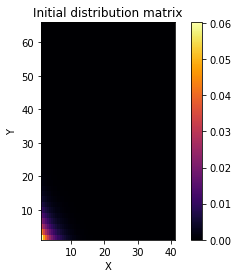

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import math

def calculate_probs(sample):
    cnt = {}
    for x in sample:
        if x not in cnt:
            cnt[x] = 1.0
        else:
            cnt[x] += 1.0
    for x in cnt.keys():
        cnt[x] /= len(sample)

    return cnt


# we will use geometrical distribution like starting sample
def generate_distribution_matrix(sample_x, sample_y):
    x_probabilities = calculate_probs(sample_x)
    y_probabilities = calculate_probs(sample_y)

    n = int(max(x_probabilities.keys()))
    m = int(max(y_probabilities.keys()))
    matrix = np.zeros((n, m))

    for x, x_probability in x_probabilities.items():
        for y, y_probability in y_probabilities.items():
            matrix[int(x) - 1][int(y) - 1] = x_probability * y_probability

    return matrix



sample_size = 1000000
p_x = 0.3
p_y = 0.2
sample_x = np.random.geometric(p_x, sample_size)
sample_y = np.random.geometric(p_y, sample_size)
matrix = generate_distribution_matrix(sample_x, sample_y)

print("Сумма вероятностей матрицы распределения: ", sum(sum(matrix)))

plt.xlabel("X")
plt.ylabel("Y")
plt.title("Initial distribution matrix")
c = plt.imshow(matrix, cmap='inferno', interpolation='nearest', origin='lower',
               extent=(1, len(matrix) + 1, 1, len(matrix[0]) + 1))
plt.colorbar(c)
plt.show()

Далее из полученной матрицы распределения сможем построить границы для работы алгоритма по генерации выборки по заданной матрице распеределения. Когда получим выборку для двумерной случайной величины, составим для нее матрицу распеределения и извлечем выборки для СВ X и СВ Y.



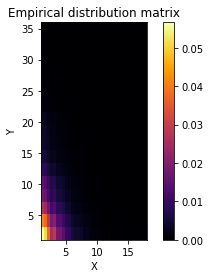

In [ ]:
def build_borders(sample):
    borders = [0.0]
    for element in sample:
        borders.append(borders[-1] + element)
    return borders


def generate_sample(sample_len, matrix):
    n = len(matrix)
    m = len(matrix[0])
    x_borders = build_borders([sum(matrix[i]) for i in range(n)])
    y_borders = build_borders([sum(matrix[:, i]) for i in range(m)])

    sample = []
    for iteration in range(sample_len):
        sample.append((0, 0))
        x = np.random.uniform()
        for i in range(n):
            if x_borders[i] < x <= x_borders[i + 1]:
                y = np.random.uniform()
                for j in range(m):
                    if y_borders[j] < y <= y_borders[j + 1]:
                        sample[-1] = (i + 1, j + 1)
                        break
                break

    return sample



sample_len = 1000
sample = generate_sample(sample_len, matrix)

X_sample = np.array([sample[i][0] for i in range(sample_len)])
Y_sample = np.array([sample[i][1] for i in range(sample_len)])
matrix_from_sample = generate_distribution_matrix(X_sample, Y_sample)
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Empirical distribution matrix")
c = plt.imshow(matrix_from_sample, cmap='inferno', interpolation='nearest', origin='lower',
               extent=(1, len(matrix_from_sample) + 1, 1, len(matrix_from_sample[0]) + 1))
plt.colorbar(c)
plt.show()

Построим гистограммы для СВ X и СВ Y.

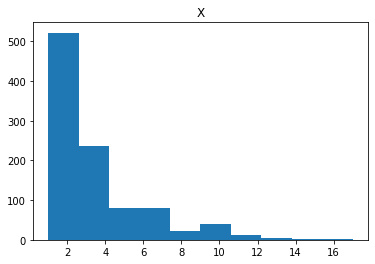

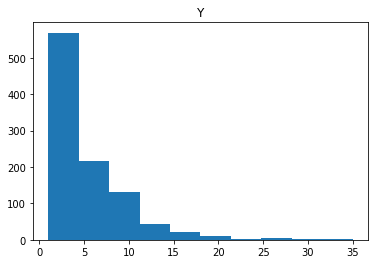

In [ ]:
plt.title("X")
plt.hist(X_sample)
plt.show()

plt.title("Y")
plt.hist(Y_sample)
plt.show()


Проверим соответствие выборки на выборку с геомитрическим законом распределения используя критерий хи-квадрат. Для этого извлечем частоты элементов из нашей выборки и воспользуемся методом  scipy.stats.chisquare.



In [ ]:
def get_frequencies(sample, max_element):
    freq = []
    cnt = {}
    for element in sample:
        if element not in cnt:
            cnt[element] = 1
        else:
            cnt[element] += 1

    for i in range(1, max_element + 1):
        if i not in cnt:
            freq.append(1)
        else:
            freq.append(cnt[i])

    return freq


geometrical_x_sample = np.random.geometric(p_x, sample_len)
max_element_in_both_samples = max(max(geometrical_x_sample), max(X_sample))

x_frequences = get_frequencies(X_sample, max_element_in_both_samples)
theoretical_frequences = get_frequencies(geometrical_x_sample, max_element_in_both_samples)

print(x_frequences)
print(theoretical_frequences)

print("Критерий хи-квадрат: ", stats.chisquare(x_frequences, f_exp=theoretical_frequences).statistic)
print("Число степеней свободы: ", len(x_frequences) - 1)




[301, 221, 140, 96, 80, 48, 32, 23, 22, 17, 7, 4, 5, 2, 1, 1, 1, 1, 1, 1, 1, 1]
[307, 205, 145, 83, 65, 64, 38, 34, 18, 14, 7, 4, 3, 3, 2, 3, 1, 1, 2, 1, 1, 1]
Критерий хи-квадрат:  21.074079146618676
Число степеней свободы:  21


In [ ]:
def point_estimate_mean(sample):
    return sum(sample) / len(sample)
def point_estimate_variance(sample):
    mean = point_estimate_mean(sample)
    result = 0.0
    for element in sample:
        result += (element - mean) ** 2
    return result / (len(sample) - 1)
def confidence_interval_mean(sample, significance_level):
    n = len(sample)
    standart_deviation = math.sqrt(point_estimate_variance(sample))
    u_coefficient = stats.norm.ppf(1 - significance_level / 2)
    epsilon = standart_deviation * u_coefficient / math.sqrt(n)
    return (-epsilon, epsilon)

def confidence_interval_variance(sample, significance_level):
    n = len(sample)
    left_chi_coefficient = stats.chi2.ppf(1 - significance_level / 2, n - 1)
    right_chi_coefficient = stats.chi2.ppf(significance_level / 2, n - 1)
    est_variance = point_estimate_variance(sample)
    standart_deviation = math.sqrt(est_variance)
    epsilon = (n - 1) * est_variance
    return (epsilon / left_chi_coefficient, epsilon / right_chi_coefficient)

print("X:")

print("Теоретическое M[X]: ", 1.0 / p_x)
print("Теоретическая D[X]: ", (1.0 - p_x) / (p_x ** 2))

M_X = point_estimate_mean(X_sample)
D_X = point_estimate_variance(X_sample)
print("Точечная оценка M[X]: ", M_X)
print("Точечная оценка D[X]: ", D_X)

M_X_borders = confidence_interval_mean(X_sample, 0.01)
print('Доверительный интервал для M[X] при уровне значимости 0.01: ')
print("[", M_X + M_X_borders[0], ",",  M_X + M_X_borders[1], "]")

D_X_borders = confidence_interval_variance(X_sample, 0.01)
print('Доверительный интервал для D[X] при уровне значимости 0.01: ')
print("[", D_X_borders[0], ",",  D_X_borders[1], "]")

print("Y:")

print("Теоретическое M[Y]: ", 1.0 / p_y)
print("Теоретическая D[Y]: ", (1.0 - p_y) / (p_y ** 2))

M_Y = point_estimate_mean(Y_sample)
D_Y = point_estimate_variance(Y_sample)
print("Точечная оценка M[Y]: ", M_Y)
print("Точечная оценка D[Y]: ", D_Y)

M_Y_borders = confidence_interval_mean(Y_sample, 0.01)
print('Доверительный интервал для M[Y] при уровне значимости 0.01: ')
print("[", M_Y + M_Y_borders[0], ",",  M_Y + M_Y_borders[1], "]")

D_Y_borders = confidence_interval_variance(Y_sample, 0.01)
print('Доверительный интервал для D[Y] при уровне значимости 0.01: ')
print("[", D_Y_borders[0], ",",  D_Y_borders[1], "]")




X:
Теоретическое M[X]:  3.3333333333333335
Теоретическая D[X]:  7.777777777777778
Точечная оценка M[X]:  3.34016
Точечная оценка D[X]:  7.784629020693522
Доверительный интервал для M[X] при уровне значимости 0.01: 
[ 3.31743331774552 , 3.36288668225448 ]
Доверительный интервал для D[X] при уровне значимости 0.01: 
[ 7.695689320662602 , 7.875049933192397 ]
Y:
Теоретическое M[Y]:  5.0
Теоретическая D[Y]:  19.999999999999996
Точечная оценка M[Y]:  5.01269
Точечная оценка D[Y]:  20.124790211825758
Доверительный интервал для M[Y] при уровне значимости 0.01: 
[ 4.976148803772631 , 5.049231196227369 ]
Доверительный интервал для D[Y] при уровне значимости 0.01: 
[ 19.894863673275626 , 20.35854597461991 ]
